# Prediction of Bike Sharing Demand 
## *(Tigi Thomas, Daniel Dowler, Konniam Chan)*
## Description of Problem

Use **Historical rental usage** patterns and **Weather data** to **Forecast Bike Rental demand**, for a “Bike sharing system” where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. 

Hourly rental data spanning two years has been provided. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The goal is to predict the total count of bikes rented during each hour covered by the test set.  
[Official Kaggel Competition Details](https://www.kaggle.com/c/bike-sharing-demand)

The test data set is interspersed with the train data set. In a real-world setting, one would not have train data that come after the test data. For the early part of the notebook, we will proceed with using the whole data set (which includes past and future data) to predict the test data. This aids in demonstration of methods and check our progress on the public leaderboard (who indoubtedly would use all data points available). A later section will demonstrate the use of past data only. As we will see, the distinction is relatively minor, in terms of prediction performance.

**Data Fields Provided**

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
**holiday** - whether the day is considered a holiday  
**workingday** - whether the day is neither a weekend nor holiday  
**weather** -  
  1: Clear, Few clouds, Partly cloudy, Partly cloudy  
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**temp** - temperature in Celsius  
**atemp** - "feels like" temperature in Celsius  
**humidity** - relative humidity  
**windspeed** - wind speed  
**casual** - number of non-registered user rentals initiated  
**registered** - number of registered user rentals initiated  
**count** - number of total rentals

[Download the data here](https://www.kaggle.com/c/bike-sharing-demand/data)

## Baseline Analysis

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.cross_validation import cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import make_scorer

# Set randomizer seed
np.random.seed(0)

We start by simply loading the data and extracting the most primitive features. We'll establish a baseline before continuing to more advanced algorithms and feature engineering.

In [2]:
# Prepare data for model fitting ()
# Train and test sets on local machines
file_paths = ['~/datasets/bike/train.csv', '~/datasets/bike/test.csv']

# Define function to clean train and test data
def clean_data(path):
    """
    Input: path of csv files (train or test)
    Output: dataframe with features deleted and added
    """
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    return df

# Clean train and test csv files
df_train = clean_data(file_paths[0])
df_test = clean_data(file_paths[1])

In [3]:
## Get feature names and preview data
features = df_train.columns.values[:-3]
print ("Feature names: ")
print (features)
# Print out first 5 training examples with outcome variables
print ("\nFirst 5 examples: ")
print (df_train.head(5))

# Array sizes
print ("\nTrain data: {}".format(df_train.shape))
print ("Test data: {}".format(df_test.shape))

Feature names: 
['season' 'holiday' 'workingday' 'weather' 'temp' 'atemp' 'humidity'
 'windspeed']

First 5 examples: 
                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  
datetime                                                             
2011-01-01 00:00:00        81          0       3          13     16  
2011-01-01 01:00:00        80          0       8          32     40  
2011-01-01 02:00:00        80          0       5          27     32  
2011-

### Baseline
The preferred evaluation criteria of this Kaggle competition is the RMSLE metric. First we start by prediction the outcome variable with its mean to set the baseline. We evaluate our results with a 5-fold validation, to balance between training a good model with low bias and having sufficient test examples to check accuracy. We find a 5-fold score fairly close to the test score obtained by submission to Kaggle.

In [4]:
## Evaluation criteria: Root Mean Squared Logarithmic Error (RMSLE)
def RMSLE(actual, predicted):
    """
    Inputs: actual counts, predicted counts
    Outputs: Root Mean Squared Logarithmic Error
    """
    return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

# Make a scoring object for GridSearch to use
RMSLE_scorer = make_scorer(RMSLE, greater_is_better=False)

In [5]:
## Baseline prediction (using the mean as a model)
# Evaluate with 5-fold cross-validation
base_preds = cross_val_predict(DummyRegressor(strategy="mean"), df_train[features], df_train['count'], cv=5)
print ("Baseline RMSLE: {:.3f}".format(RMSLE(df_train['count'], base_preds)))
print ("Baseline R2: {:.3f}".format(metrics.r2_score(df_train['count'], base_preds)))

Baseline RMSLE: 1.591
Baseline R2: -0.072


### Linear Regression
Next up we'll try a linear regression model to see how much this improves upon the baseline.

In [6]:
## Default parameters
lr_preds = cross_val_predict(LinearRegression(), df_train[features], df_train['count'], cv=5)
# Prevent predictions from going below zero
lr_preds[lr_preds<0] = 0
print ("LR RMSLE: {:.3f}".format(RMSLE(df_train['count'], lr_preds)))
print ("LR R2: {:.3f}".format(metrics.r2_score(df_train['count'], lr_preds)))

LR RMSLE: 1.479
LR R2: 0.141


Linear regression is able to bring down the RMSLE slightly and improve R2 to 14%.

## Data Exploration and Feature Engineering

How do users use the bike sharing system? This could give us insight into which features we need to include in our model.

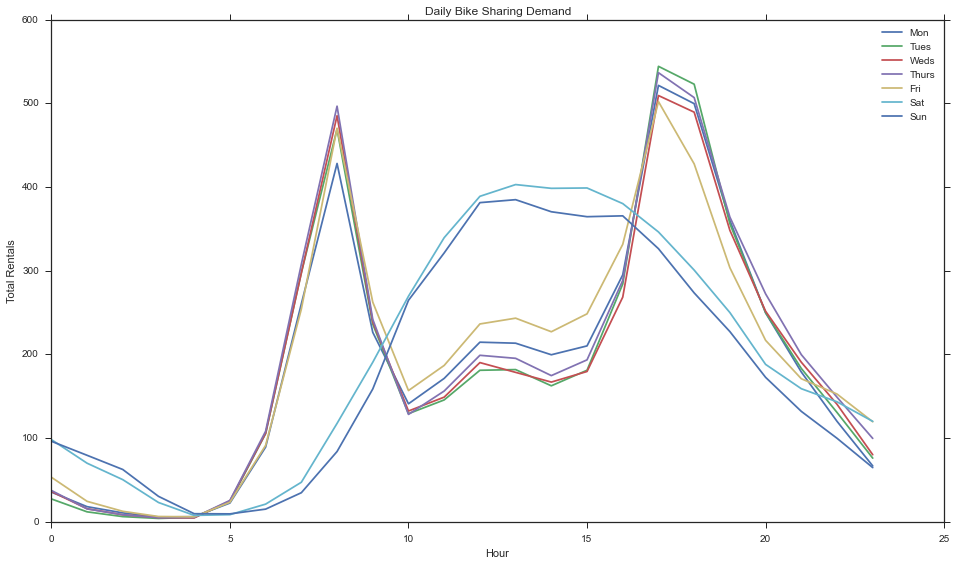

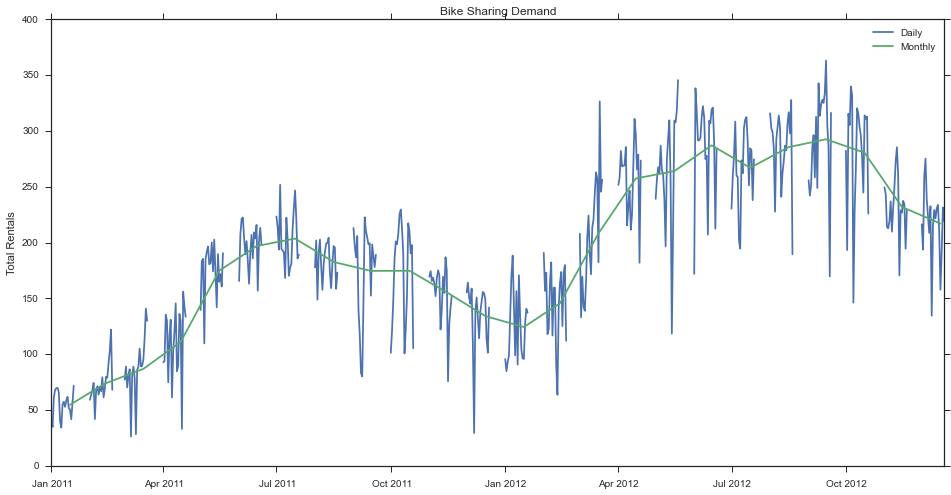

In [7]:
## How do users use the bike sharing system?
# Set plot styles
sns.set_style("ticks")

# Add dayofweek and hour feature
df_train["dayofweek"] = df_train.index.dayofweek
df_train["hour"] = df_train.index.hour

# Trends for demand daily for working day and non working day
df_hourly_dayofweek = df_train.groupby(["dayofweek", "hour"]).mean()
day_labels = ["Mon", "Tues", "Weds", "Thurs", "Fri", "Sat", "Sun"]
plt.figure(figsize = (16,9))
for d in range(7):
    plt.plot(df_hourly_dayofweek.ix[d].index, df_hourly_dayofweek.ix[d]['count'], label=day_labels[d])
title = plt.title('Daily Bike Sharing Demand')
xlabel = plt.xlabel('Hour')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

# Trends for demand over time
# Aggregate by day and by month
df_dailymean = df_train.resample('D', how='mean')
df_monthlymean = df_train.resample('M', how='mean')
# Plot time series
plt.figure(figsize = (16,8))
dailyplot = plt.plot(df_dailymean.index, df_dailymean['count'], label="Daily")
monthlyplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_monthlymean['count'], label="Monthly")
title = plt.title('Bike Sharing Demand')
ylabel = plt.ylabel('Total Rentals')
legend = plt.legend(frameon=False)

The first figure examines usage pattern on each day of the week. We clearly see that on weekdays, usage spikes around 8am and 5pm. This likely corresponds to people using the bike-sharing service as commute transportation. On weekends, the usage has a broad peak from 12pm to 4pm. People are likely using these bikes for leisure.  
The second figure shows the very high variance nature of bike sharing. The daily means fluctuate wildly. However, there seems to be a seasonal component to it. There is a local maximum around July, and a local minimum around January. The overall trend is positive (i.e. people use more bikes in 2012 compared to 2011).

We used the above observations to engineer a few features:  
- **year**: accounts for the overall growth of the system
- **month**: accounts for seasonality
- **dayofyear**: a finer version of seasonality
- **hour**: captures daily fluctuation
- **dayofweek**: captures the behavior resulting from our 7-day based schedule
- **day**: captures behavior around the month, i.e people set goals to bike more in the beginning of the month
- **commute**: captures the peaks of commute transportation

In [8]:
## Prepare data for model fitting, with preliminary feature engineering
# Train and test sets on local machines
file_paths = ['~/datasets/bike/train.csv', '~/datasets/bike/test.csv']

# Define function to clean train and test data
def clean_data(path):
    """
    Input: path of csv files (train or test)
    Output: dataframe with features deleted and added
    """
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    # Split datetime up into 6 components
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["day"] = df.index.day
    # Fill in missing values in humidity and windspeed
    df.loc[df["humidity"]==0, "humidity"] = np.nan
    df.loc[df["windspeed"]==0, "windspeed"] = np.nan    
    # Fill forward first, then, backwards (for first few missing values)
    df = df.fillna(method="ffill").fillna(method="bfill")
    # Features addition
    # Commute: account for spike in demand around commute hours
    commute_hours = [7,8,9,16,17,18,19]
    df["commute"] = ((df["workingday"]==1) & (df["hour"].isin(commute_hours))).astype(int)
    return df

# Clean train and test csv files
df_train = clean_data(file_paths[0])
df_test = clean_data(file_paths[1])

## More Exploration and Feature Engineering

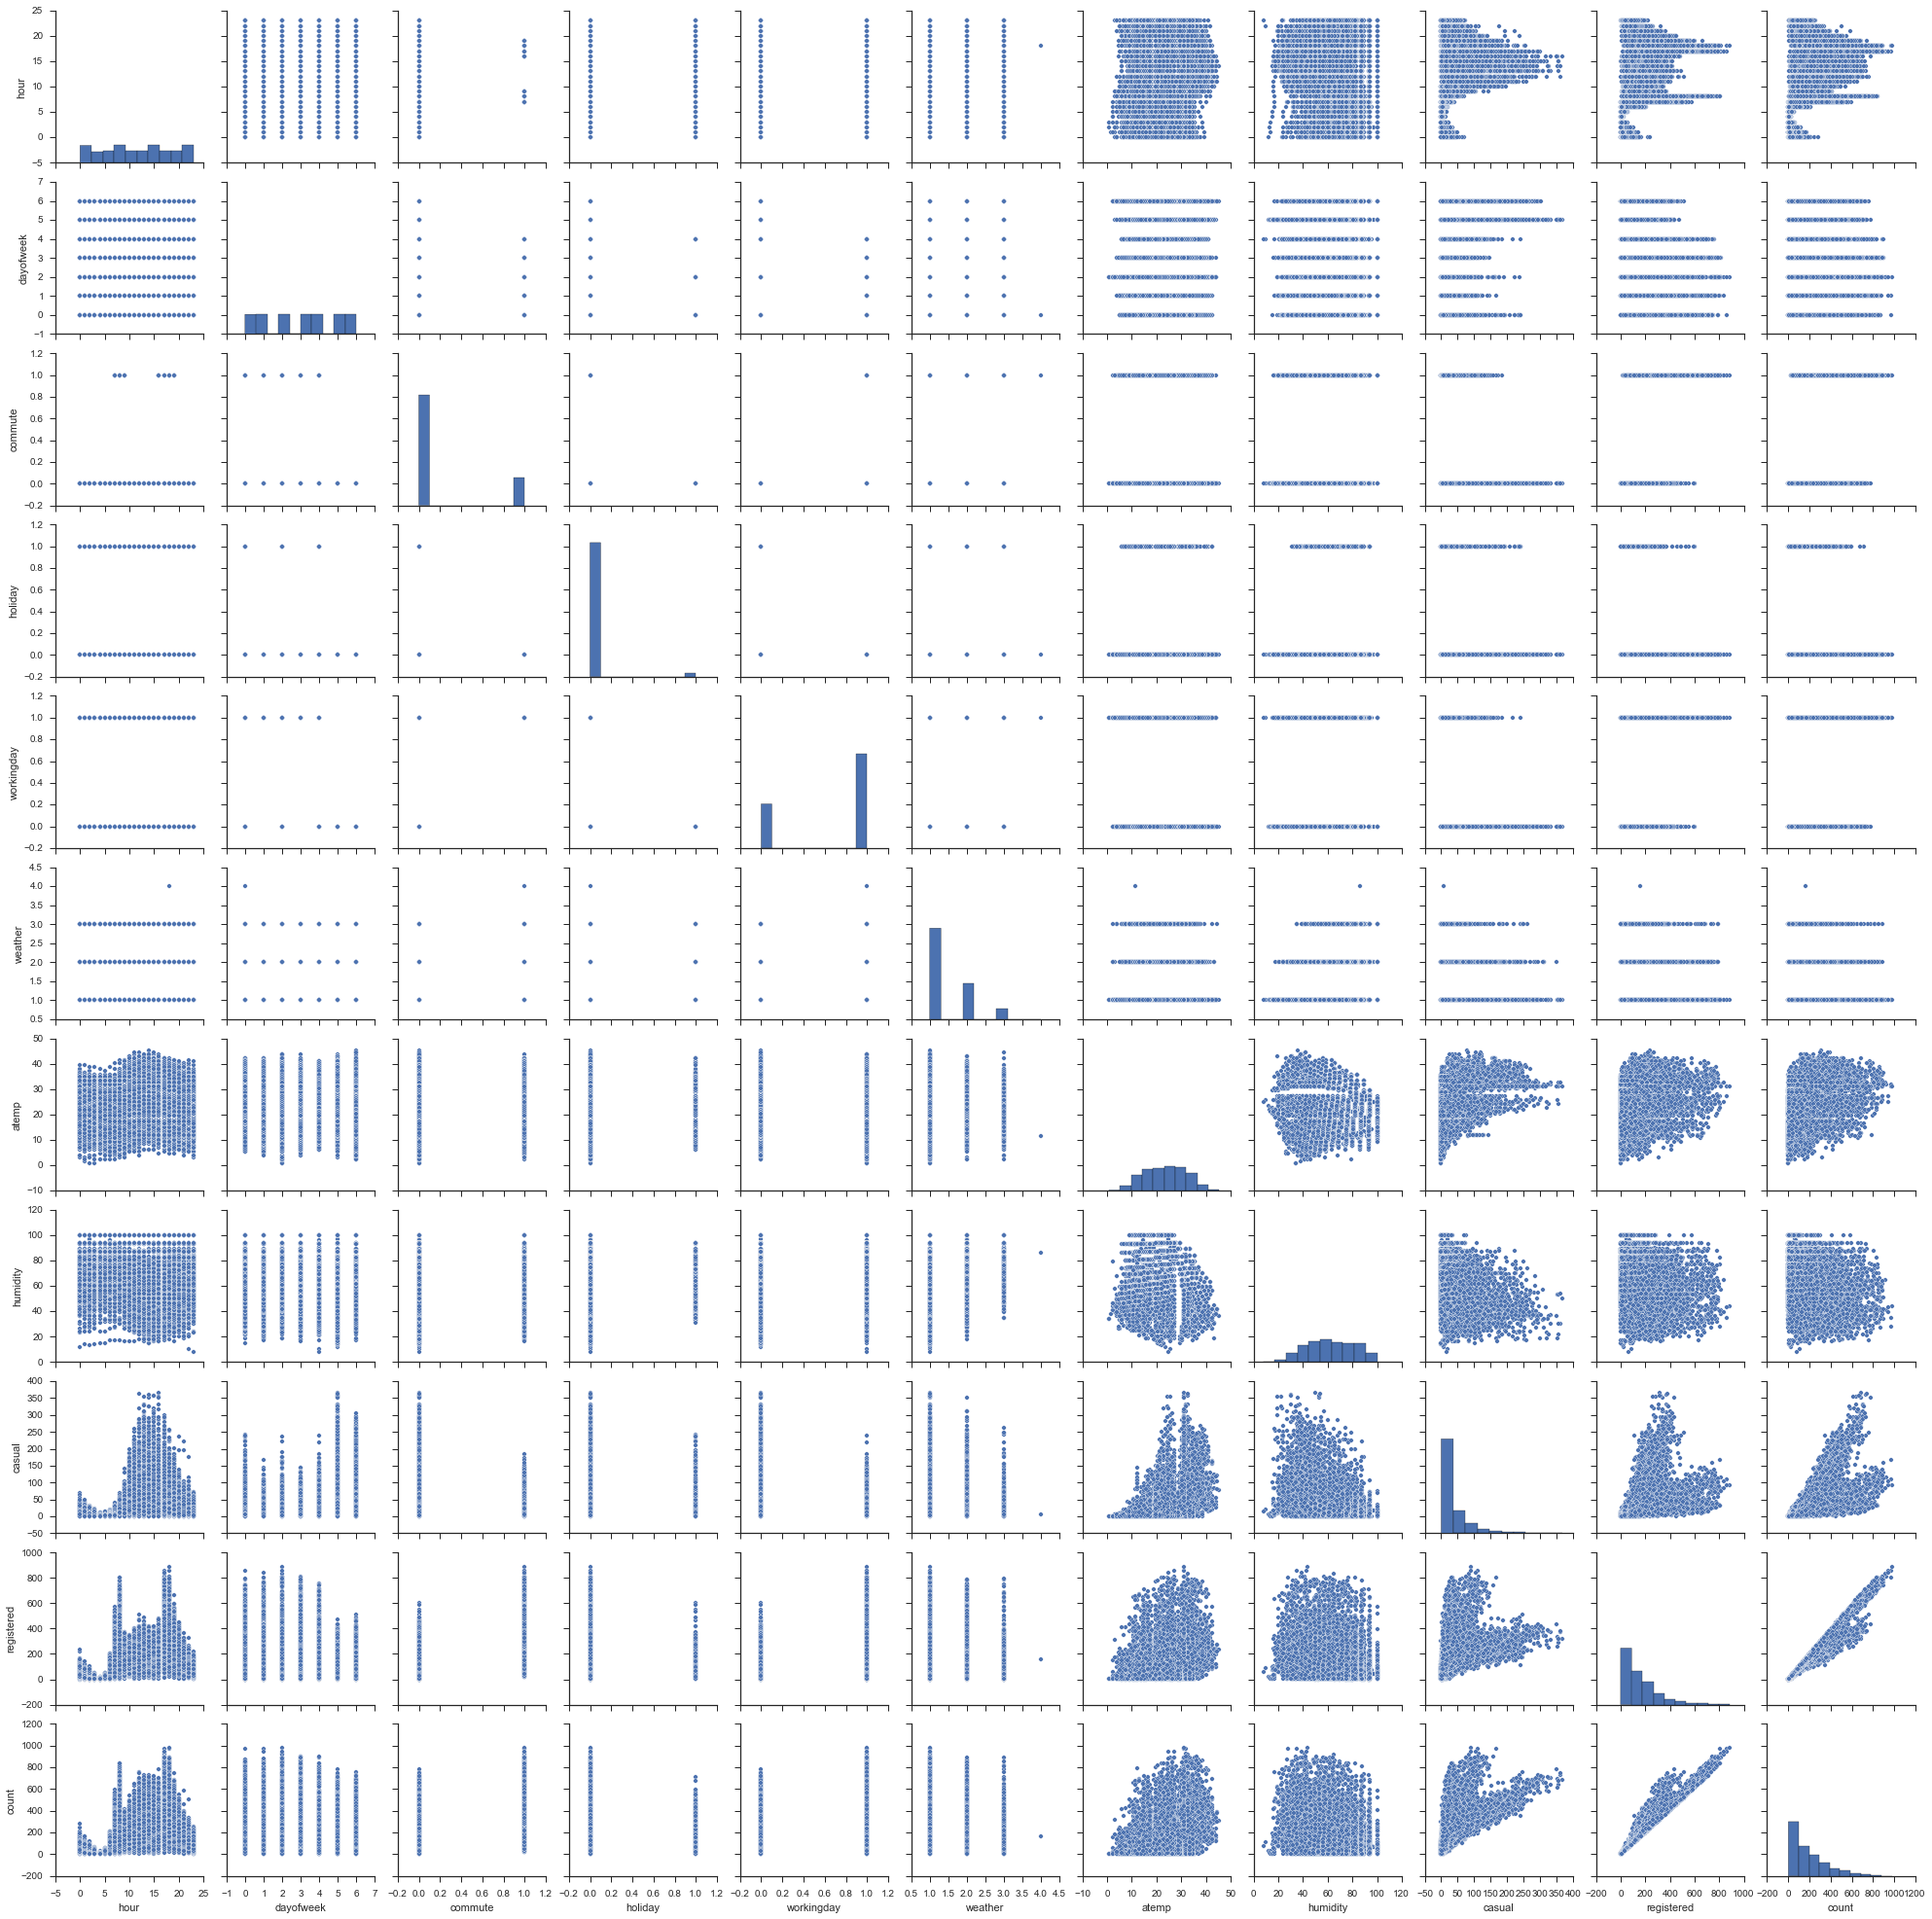

In [9]:
## More plots to get an idea of the features
figure = plt.figure(figsize=(15,15))
scatterplot = sns.pairplot(df_train[['hour', 'dayofweek', 'commute', 'holiday', 'workingday', 'weather', 'atemp', 'humidity', 
                                     'casual', 'registered', 'count']])

A few observations from the plot above:
- Casual users use bikes around noon time, and on weekends. Atemp and humidity both seem to have reasonable a moderate effect on how many people ride rikes. We can hypothesize that casual users use bikes for leisure on weekends, and are more sensitive to external weather conditions.
- Registered users behave differently from casual users. They use bikes around commute time and on weekdays. Weather conditions don't seem to matter as much for these users.
- The outcome variable has a large positive skew. Try transforming the variable with log1p function.  

Because casual and registered users behave differently, it makes sense to forecast each separately and use their sum. But let's use the total count first, then we will split them up to see if our accuracy improves.

In [10]:
## Log-Transform
df_train['log_casual'] = np.log1p(df_train['casual'])
df_train['log_registered'] = np.log1p(df_train['registered'])
df_train['log_count'] = np.log1p(df_train['count'])

# Set new features
features_to_exclude = ['casual', 'registered', 'count', 'log_casual', 'log_registered', 'log_count']
features = [feature for feature in df_train.columns.values if feature not in features_to_exclude]
print features

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'dayofyear', 'hour', 'dayofweek', 'day', 'commute']


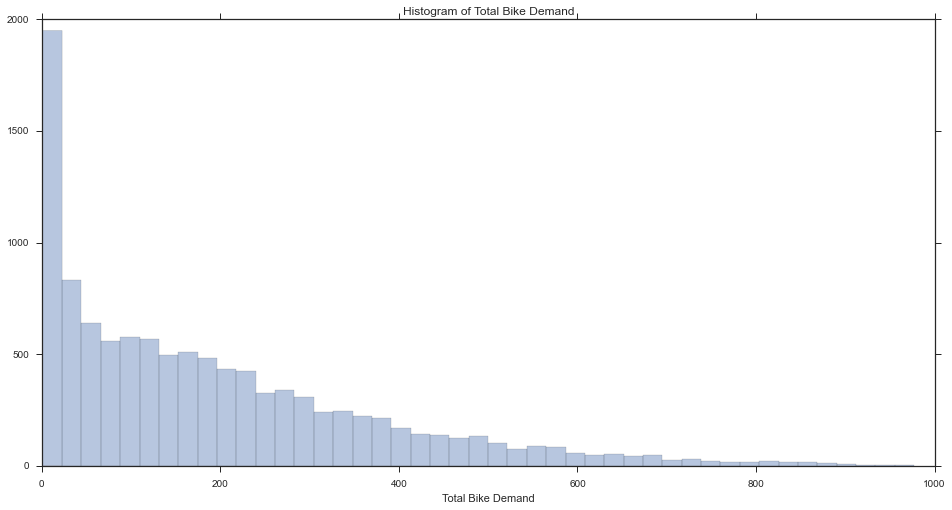

In [11]:
## Histogram of total count
sns.set_style('ticks')
plt.figure(figsize=(16,8))
histogram = sns.distplot(df_train['count'], kde=False)
title = plt.title('Histogram of Total Bike Demand')
xlabel = plt.xlabel('Total Bike Demand')

## Model Fitting
### Linear Regression
With feature engineering in place, let's first try our old friend linear regression.

In [12]:
## Linear regression with default parameters
# Forecast the log count, then exponentiate to get predictions
lr_preds = np.expm1(cross_val_predict(LinearRegression(), df_train[features], df_train['log_count'], cv=5))
print ("LR RMSLE: {:.3f}".format(RMSLE(df_train['count'], lr_preds)))
print ("LR R2: {:.3f}".format(metrics.r2_score(df_train['count'], lr_preds)))

LR RMSLE: 0.879
LR R2: 0.110


The error is reduced drastically to 0.879.

### k-Nearest Neighbors
Because our features are mostly numeric and continuous, and we have many examples relative to features, a k nearest neighbors model might work well here.

In [13]:
## kNN Regression
# Scale features first, then use 5-fold cross validation to check accuracy
k = 10
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = k, weights = "distance"))
knn_preds = np.expm1(cross_val_predict(knn_pipe, df_train[features], df_train['log_count'], cv=5))
print ("kNN RMSLE: {:.3f}".format(RMSLE(df_train['count'], knn_preds)))
print ("kNN R2: {:.3f}".format(metrics.r2_score(df_train['count'], knn_preds)))

kNN RMSLE: 0.824
kNN R2: 0.639


After some fine tuning, we improved the error to 0.824 and now explained 64% of the variance. The next thing we can try is a decision trees regressor.  

### Decision Trees
Because of its ability to model highly complicated boundaries, we expect decision tree to perform better than a kNN regression.

In [14]:
## Decision Tree Regression
# Ensure consistency of results
np.random.seed(0)
# Fit decision tree regressor
dt_preds = np.expm1(cross_val_predict(DecisionTreeRegressor(max_depth=10), 
                                      df_train[features], df_train['log_count'], cv=5))
print ("DT RMSLE: {:.3f}".format(RMSLE(df_train['count'], dt_preds)))
print ("DT R2: {:.3f}".format(metrics.r2_score(df_train['count'], dt_preds)))

DT RMSLE: 0.577
DT R2: 0.747


### Random Forest
Random forest combines the results of many decision trees to reduce variance. We'll train a random forest model to see if it fits the data better than a decision tree.

In [15]:
## Random Forest Regressor
# Ensure consistency of results
np.random.seed(0)
# Fit random forest regressor
rf_preds = np.expm1(cross_val_predict(RandomForestRegressor(n_estimators = 100, max_features = 8, max_depth = 20), 
                             df_train[features], df_train['log_count'], cv=5, n_jobs=-1))
print ("RF RMSLE: {:.3f}".format(RMSLE(df_train['count'], rf_preds)))
print ("RF R2: {:.3f}".format(metrics.r2_score(df_train['count'], rf_preds)))

RF RMSLE: 0.451
RF R2: 0.835


Indeed, random forest performed quite well. We can try tuning the hyperparameters to see if we can improve upon the above results.

In [16]:
# Random Forest Grid Search (Parameters Tuning)
# Ensure consistency of results
np.random.seed(0)
# Set up GridSearchCV
rf_params = {'n_estimators': np.arange(1,30), 
             'max_features': [8],
             'max_depth': [10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, scoring='mean_squared_error', cv=5)
rf_grid.fit(df_train[features], df_train['log_count'])
print (np.sqrt(-rf_grid.best_score_))
print (rf_grid.best_params_)

0.45237831621
{'max_features': 8, 'n_estimators': 24, 'max_depth': 20}


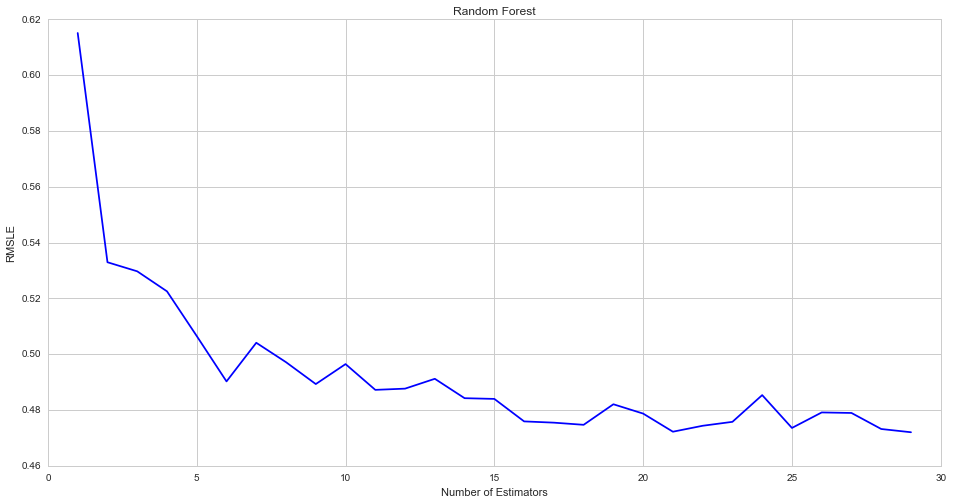

In [17]:
# Set plot styles
sns.set_style("whitegrid")
# Random forest plot
accuracies = [np.sqrt(-(rf_grid.grid_scores_[i][1])) for i in range(29)]
plt.figure(figsize=(16,8))
scatter = plt.plot(rf_params["n_estimators"], accuracies, 'b')
title = plt.title ("Random Forest")
xlabel = plt.xlabel ("Number of Estimators")
ylabel = plt.ylabel ("RMSLE")

Note: This error (computed by GridSearchCV is computed differently from previous calcuations) and is higher than before.  
The error seemed to stop getting lower starting at around n=20. In other words, 20 decision trees are enough to get most of the benefits from random forest in this case.

### Gradient Boost
Let's try a boosting strategy. Boosting involves training many base estimators sequentially. The estimator in each iteration is trained to correct for mistakes made by the previous estimator. We'll try the gradient boosting algorithm.

In [18]:
## Gradient Boosting Regressor
# Ensure consistency of results
np.random.seed(0)
# Fit gradient boost
gb_preds = np.expm1(cross_val_predict(GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=20),
                              df_train[features], df_train['log_count'], cv=5))
print ("Gradient Boost RMSLE: {:.3f}".format(RMSLE(df_train['count'], gb_preds)))
print ("Gradient Boost R2: {:.3f}".format(metrics.r2_score(df_train['count'], gb_preds)))

Gradient Boost RMSLE: 0.432
Gradient Boost R2: 0.857


Gradient boost performed a little better than the rest after some tuning.

### Predicting casual and registered users separately
As seen from the scatterplot matrix above, casual and registered bike users behave quite differently. We can take advantage of the split that is provided in the data. We can fit two different models to each group of users, then add them up. Doing so should improve the performance of a standalone model.

In [19]:
# Ensure consistency of results
np.random.seed(0)
# Function to calculate predictions from a chosen model                             
def casual_reg_predict (casual_model, reg_model):
    '''
    Input: model to fit
    Output: predictions made by 5-fold CV, predicting casual and registered individually then summing
    '''
    # Casual
    preds_casual = np.expm1(cross_val_predict(casual_model, df_train[features], df_train['log_casual'], cv=5, n_jobs=-1))
    print ("Casual RMSLE: {:.3f}".format(RMSLE(df_train['casual'], preds_casual)))
    print ("Casual R2: {:.3f}".format(metrics.r2_score(df_train['casual'], preds_casual)))

    # Registered
    preds_reg = np.expm1(cross_val_predict(reg_model, df_train[features], df_train['log_registered'], cv=5, n_jobs=-1))
    print ("Registered RMSLE: {:.3f}".format(RMSLE(df_train['registered'], preds_reg)))
    print ("Registered R2: {:.3f}".format(metrics.r2_score(df_train['registered'], preds_reg)))
    
    # Total
    preds_total = preds_casual + preds_reg
    print ("Total RMSLE: {:.3f}".format(RMSLE(df_train['count'], preds_total)))
    print ("Total R2: {:.3f}".format(metrics.r2_score(df_train['count'], preds_total)))
    return preds_total

# Use a tuned gradient boosting model
gb_preds_total = casual_reg_predict(GradientBoostingRegressor(learning_rate=0.05, max_features=10, max_depth=6, min_samples_leaf=20),
                          GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_features=10, max_depth=10, min_samples_leaf=20))

Casual RMSLE: 0.547
Casual R2: 0.817
Registered RMSLE: 0.411
Registered R2: 0.880
Total RMSLE: 0.404
Total R2: 0.883


The splitting of the prediction between casual and registered helped improve the model.

### Feature Importances
We can examine how much each feature matter in the casual model and the registered models. The Gini importance corresponds how much the mean squared error gets reduced by splitting on that feature (equivalent to looking at information gain for classification problems).

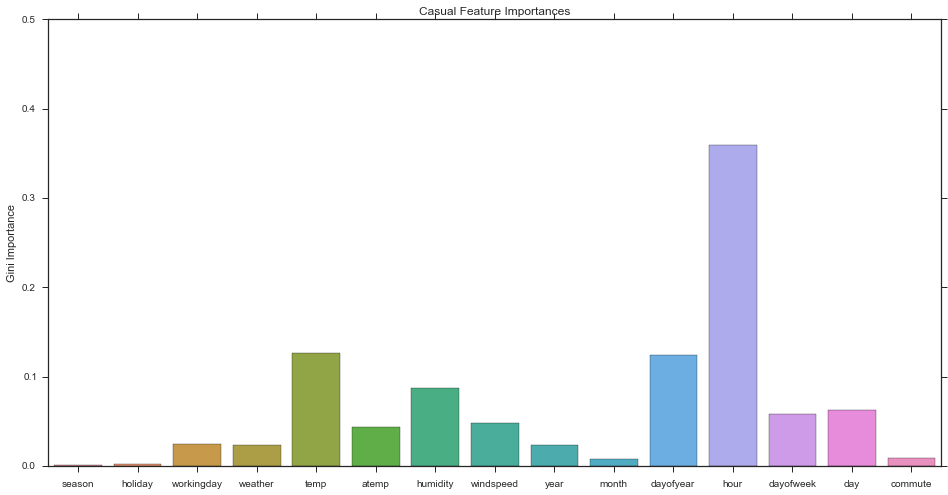

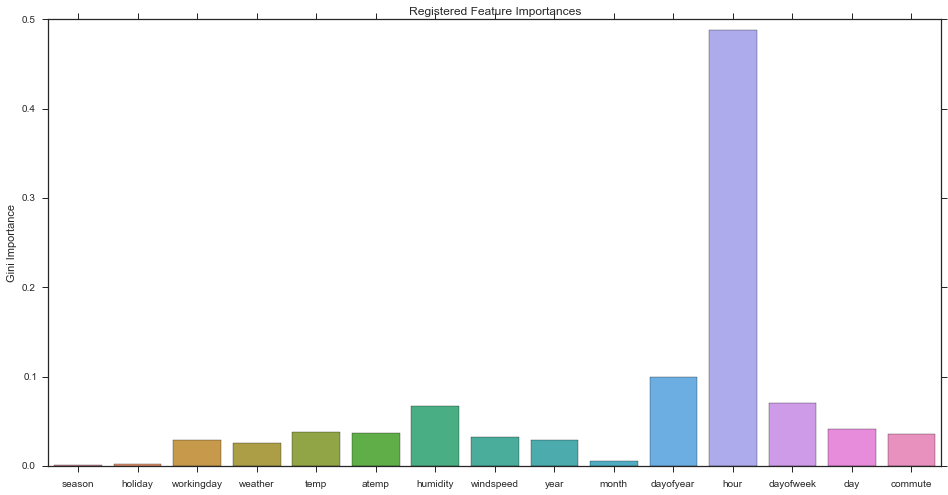

In [32]:
# Fit models
casual = GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=20)
casual.fit(df_train[features], df_train['log_casual'])
reg = GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=20)
reg.fit(df_train[features], df_train['log_registered'])

# Plot feature importances
sns.set_style('ticks')
titles = ['Casual Feature Importances', 'Registered Feature Importances']
for k, values in enumerate([casual.feature_importances_, reg.feature_importances_]):
    plt.figure(figsize=(16,8))
    ax = sns.barplot(x=features, y=values)
    title = plt.title(titles[k])
    ylabel = plt.ylabel("Gini Importance")
    yaxis = plt.ylim(0, 0.50)

Casual users are driven more by the temperature and humidity. Registered users are driven by hours and commute. Perhaps this is expected, but it is nice to see that our model confirms our real-life intuitions.

### Error Analysis

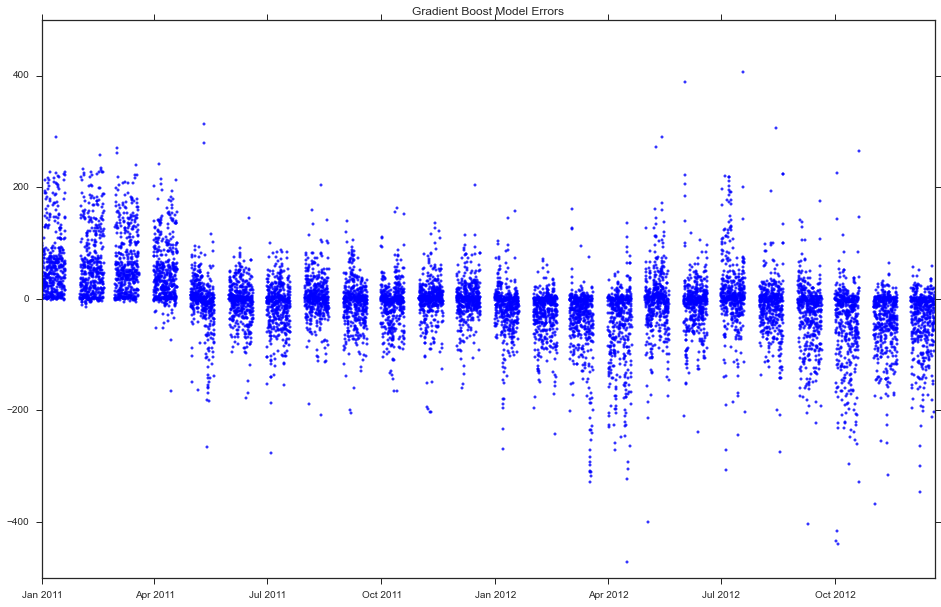

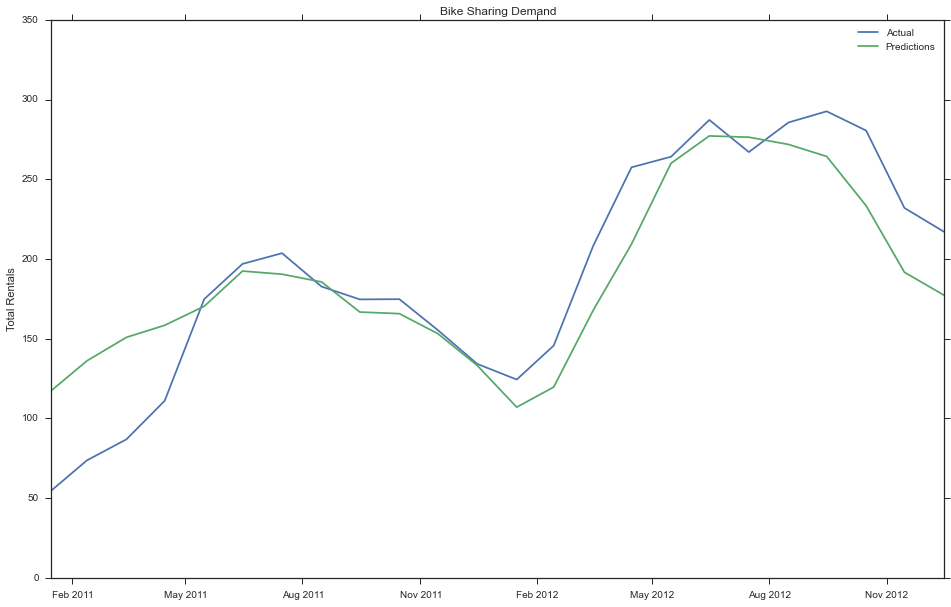

In [33]:
## Error Analysis
sns.set_style('ticks')
# Plot errors over time
errors = gb_preds_total-df_train['count']
plt.figure(figsize = (16,10))
plt.plot(df_train.index, errors, 'bo', alpha=0.8, markersize=3)
title = plt.title('Gradient Boost Model Errors')

# Compare a monthly mean version of predictions with the actual figures
df_preds = pd.DataFrame({'gb_preds':gb_preds_total}, index=df_train.index)
df_preds_monthly = df_preds.resample('M', how='mean')

# Plot
plt.figure(figsize = (16,10))
monthlyplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_monthlymean['count'], label="Actual")
predsplot = plt.plot(df_monthlymean.index - pd.DateOffset(days=15), df_preds_monthly['gb_preds'], label="Predictions")
title = plt.title('Bike Sharing Demand')
ylabel = plt.ylabel('Total Rentals')
yaxis = plt.ylim(0,350)
legend = plt.legend(frameon=False)

We see from the error plot that our model tends to underestimate in the beginning of the data set and underestimate towards the end. This happens because of the nature of cross validation and the lack of autocorrelation modeling. In cross validation, we use part of the train data to predict the rest of the train data. If we are predicting the backend of the dataset, we'll use the front 80% (for 5-fold CV) to predict the back 20%. Because our model does not have trend information, if the trend is increasing, it won't be able to adjust for it. We can incorporate findings from time series analysis to address this problem.

## Attribution of Improvements
We submitted to Kaggle with the Gradient Boosting model and obtained a score of 0.41741, rank 422. Here we document how we improved with each iteration.

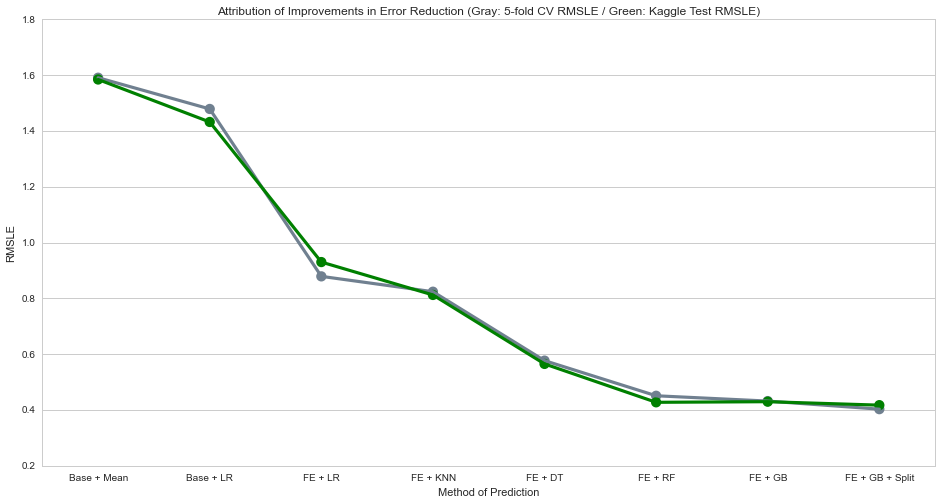

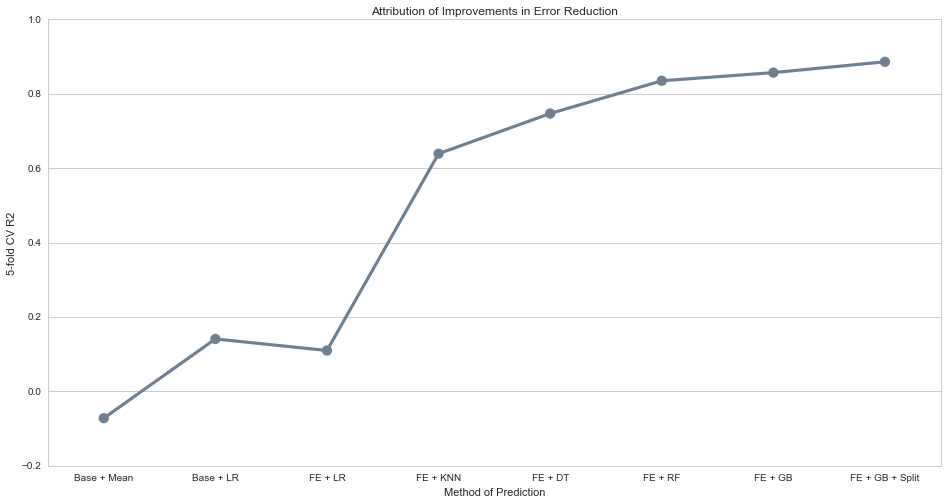

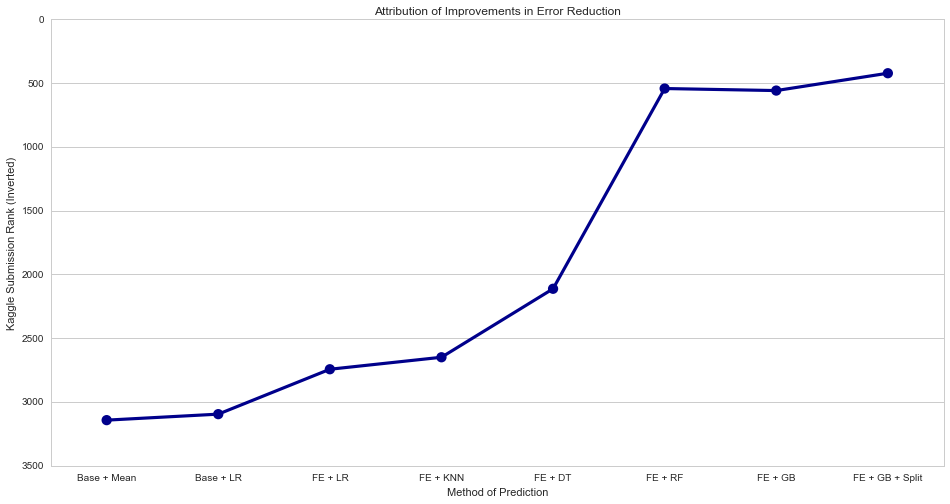

In [22]:
# We'll collect the CV errors and errors on the test set submission on Kaggle
# 3252 susbmissions total
attribution = pd.DataFrame({'reg_names': ['Base + Mean', 'Base + LR', 'FE + LR', 'FE + KNN', 'FE + DT', 'FE + RF', 'FE + GB', 'FE + GB + Split'],
                            'cv_errors': [1.591, 1.479, 0.879, 0.824, 0.577, 0.451, 0.432, 0.403],
                            'cv_R2': [-0.072, 0.141, 0.11, 0.639, 0.747, 0.835, 0.857, 0.886],
                            'test_errors': [1.58456, 1.43234, 0.93024, 0.81236, 0.56517, 0.42757, 0.42977, 0.41741],
                            'kaggle_rank': [3142, 3095, 2743, 2649, 2112, 542, 558, 422]})
sns.set_style('whitegrid')
# Plot RMSLE
plt.figure(figsize=(16,8))
sns.pointplot(x='reg_names', y='cv_errors', data=attribution, color='slategrey')
sns.pointplot(x='reg_names', y='test_errors', data=attribution, color='green')
title = plt.title('Attribution of Improvements in Error Reduction (Gray: 5-fold CV RMSLE / Green: Kaggle Test RMSLE)')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("RMSLE")
# Plot CV R2
plt.figure(figsize=(16,8))
sns.pointplot(x='reg_names', y='cv_R2', data=attribution, color='slategrey')
title = plt.title('Attribution of Improvements in Error Reduction')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("5-fold CV R2")
# Plot Kaggle rank
plt.figure(figsize=(16,8))
sns.pointplot(x='reg_names', y='kaggle_rank', data=attribution, color='darkblue')
title = plt.title('Attribution of Improvements in Error Reduction')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("Kaggle Submission Rank (Inverted)")
plt.gca().invert_yaxis()

## Predicting with past data only
In a real-world business settings, we would only have past data in forecasting. We can restrict ourselves to this condition by a slight tweak in our evaluation process.  
We can train a model for each month of test data (10 days provided in each month). Each model will be trained on data that is available prior to the test data. Because there are 24 months of test data, we need to train 24 models. For simplicity, we will use the same hyperparameters for all 24 models. In reality, each model should be tuned because the train data available to each model is different.

In [23]:
# Add an indicator to indicate how many months has elapsed since the first example
for df in [df_train, df_test]:
    df['month_beg'] = (df['year'] - 2011)*12 + df['month']

In [24]:
# Use same model for all 24 months
models = [GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=20) for k in range(24)]

# Function to train using past data only
def predict_pastdata(models):
    errors = []
    # Train 24 models by iterating through each month
    for m in range(24):
        # Take data at or prior to that month
        past_data = df_train.ix[df_train['month_beg'] <= m+1, :]
        # Extract values to faciliate indexing problems
        past_data_X = past_data[features].values
        past_data_Y = past_data['count'].values
        # Split data into test set and dev set at 80% (train set comes before dev set)
        n = past_data_X.shape[0]
        split = np.ceil(0.8*n)
        train_data, dev_data = past_data_X[:split], past_data_X[split:]
        train_labels, dev_labels = past_data_Y[:split], past_data_Y[split:]
        # Train model and chepck for accuracy (fit to log)        
        models[m].fit(train_data, np.log1p(train_labels))
        preds = np.expm1(models[m].predict(dev_data))
        errors.append(RMSLE(preds, dev_labels))
    print np.round(errors, 3)
    print ('The average RMSLE is: {:.3f}'.format(np.mean(errors)))
predict_pastdata(models)

[ 0.542  0.355  0.44   0.49   0.576  0.345  0.338  0.25   0.342  0.368
  0.358  0.339  0.575  0.684  0.77   0.513  0.435  0.406  0.31   0.319
  0.317  0.307  0.375  0.335]
The average RMSLE is: 0.420


This demonstrates how one can predict outcomes using past data only. The result looks to be comparable to the previous approach of using all data. This means that future data is not highly useful in this case.   
Here we iterate through each month of test data and predict bike sharing demand using data available previous to the time of the test data.

In [25]:
# Use same model for all 24 months
models = [GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=20) for k in range(24)]

# Predict the test set and submit to Kaggle
# Modify the above function to return predictions
def kaggle_pastdataonly(models):
    # Train 24 models by iterating through each month
    preds = []
    for m in range(24):
        # Take data at or prior to that month
        past_data = df_train.ix[df_train['month_beg'] <= m+1, :]
        # Current month's test data
        current_test = df_test.ix[df_test['month_beg'] == m+1, :]
        # Train models and make predictions on test set      
        models[m].fit(past_data[features], past_data['log_casual'])
        casual_preds = np.expm1(models[m].predict(current_test[features]))
        models[m].fit(past_data[features], past_data['log_registered'])
        reg_preds = np.expm1(models[m].predict(current_test[features]))
        preds = np.append(preds, casual_preds + reg_preds)
    return preds
preds_pastdataonly = kaggle_pastdataonly(models)

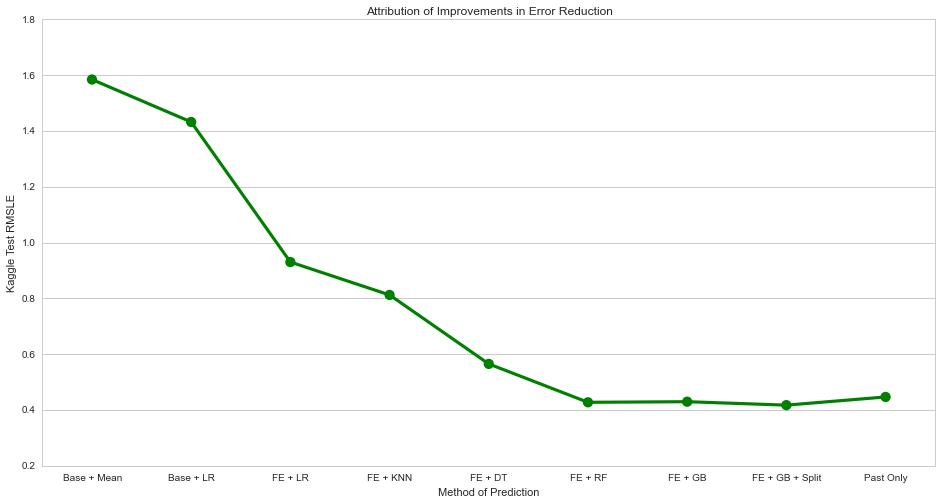

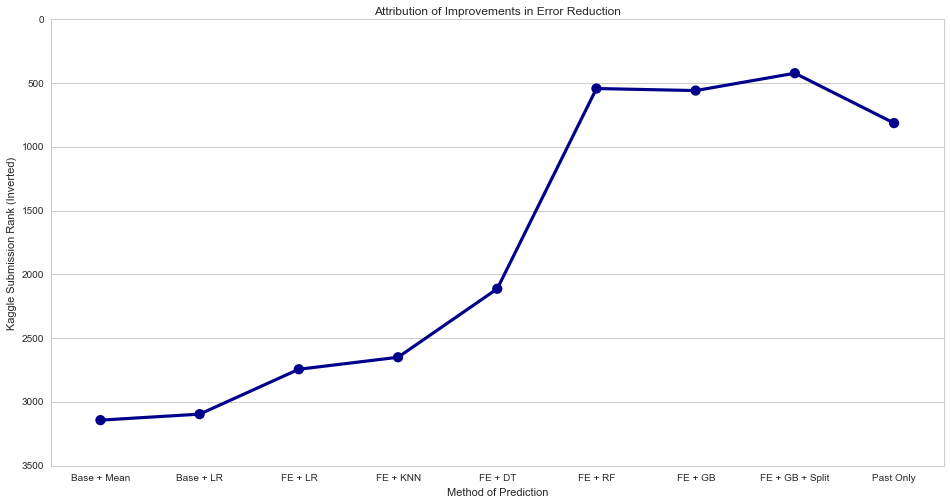

In [26]:
# Update attribution of improvement with past data prediction
sns.set_style('whitegrid')

# We'll collect the CV errors and errors on the test set submission on Kaggle
# 3252 susbmissions total
attribution_withpast = pd.DataFrame({'reg_names': ['Base + Mean', 'Base + LR', 'FE + LR', 'FE + KNN', 'FE + DT', 'FE + RF', 'FE + GB', 'FE + GB + Split', 'Past Only'],
                            'test_errors': [1.58456, 1.43234, 0.93024, 0.81236, 0.56517, 0.42757, 0.42977, 0.41741, 0.44673],
                            'kaggle_rank': [3142, 3095, 2743, 2649, 2112, 542, 558, 422, 813]})
# Plot RMSLE
plt.figure(figsize=(16,8))
sns.pointplot(x='reg_names', y='test_errors', data=attribution_withpast, color='green')
title = plt.title('Attribution of Improvements in Error Reduction')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("Kaggle Test RMSLE")

# Plot Kaggle rank
plt.figure(figsize=(16,8))
sns.pointplot(x='reg_names', y='kaggle_rank', data=attribution_withpast, color='darkblue')
title = plt.title('Attribution of Improvements in Error Reduction')
xlabel = plt.xlabel('Method of Prediction')
ylabel = plt.ylabel("Kaggle Submission Rank (Inverted)")
plt.gca().invert_yaxis()

Submitting the above prediction (using only past data) to Kaggle, we obtained a score of **0.44673**, for a rank of **813**/3252, which is not too far off from our previous score of 0.41741 using all data. This confirms our suspicion that future data actually didn't help us that much in previous predictions. If we have more time, we can tune each of the 24 models with different hyperparameters to improve performance.  

## Summary
In summary, both feature engineering and model tuning played an important role in improving prediction accuracy. We first approached the problem with an approach of using both past and future data to help us learn the structure of the problem and which methods work best. We settled on a few new features, log-transform of the outcome variable, and using gradient boosting to predict both casual and registered users.   

Then, like in real-world applications, we restrict ourselves to past data only. By applying the findings from the first part, we obtained a score not too worse off than before. We managed to improve from the mean model error of 1.58 to 0.45, a substantial improvement and should be highly useful in predicting bike sharing demand.

## Next Steps
- Time series analysis. Because of the autocorrelation of errors, applying time series techniques should improve the score.
- More data. A lot of external data could help improve accuracy. For example, if we can get access to traffic data, we will be able to see when traffic spikes (perhaps due to a major sport event). This would have an impact on how many people use bikes.

## Kaggle submissions

In [27]:
# Function to calculate predictions from a chosen model
def kaggle_predict (model):
    '''
    Input: prediction model to use
    Output: predictions based on count
    '''
    model.fit(df_train[features], df_train['count'])
    return model.predict(df_test[features])

# Function to calculate predictions from a chosen model
def kaggle_logpredict (model):
    '''
    Input: prediction model to use
    Output: predictions based on log_count
    '''
    model.fit(df_train[features], df_train['log_count'])
    return np.expm1(model.predict(df_test[features]))

# Function to calculate predictions from a chosen model (split casual and registered)                           
def kaggle_logpredict_split (casual_model, reg_model):
    '''
    Input: models for casual and registered users
    Output: predictions based on log counts of casual and registered users
    '''
    casual, reg = casual_model, reg_model
    casual.fit(df_train[features], df_train['log_casual'])
    reg.fit(df_train[features], df_train['log_registered'])
    return np.expm1(casual.predict(df_test[features])) + np.expm1(reg.predict(df_test[features]))

In [28]:
## Write results in Kaggle format
# Write to csv
def kaggle_submission(preds):
    out_path = '/Users/InfernoIX/datasets/bike/kaggle_submission.csv'
    df_submission = pd.DataFrame({"datetime": df_test.index, "count": preds}, columns = ["datetime", "count"])
    df_submission.to_csv(out_path, index=False)

In [29]:
# Final prediction
kaggle_submission(kaggle_logpredict_split(GradientBoostingRegressor(learning_rate=0.05, max_features=10, max_depth=6, min_samples_leaf=20), 
                                          GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_features=10, max_depth=10, min_samples_leaf=20)))

## Appendix

In [30]:
## Extra Trees
# Ensure consistency of results
np.random.seed(0)
# Fit random forest regressor
et_preds = np.expm1(cross_val_predict(ExtraTreesRegressor(n_estimators = 150, max_features = 15, max_depth = 20), 
                             df_train[features], df_train['log_count'], cv=5, n_jobs=-1))
print ("ExtraTrees RMSLE: {:.3f}".format(RMSLE(df_train['count'], et_preds)))
print ("ExtraTrees R2: {:.3f}".format(metrics.r2_score(df_train['count'], et_preds)))

ExtraTrees RMSLE: 0.444
ExtraTrees R2: 0.855


In [31]:
## Adaboost with Decision Tree Regressor
# Ensure consistency of results
np.random.seed(0)
# Fit Adaboost with decision tree regressor
ada_preds = np.expm1(cross_val_predict(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), 
                                                         n_estimators=150, learning_rate=1.5, loss='linear'),
                              df_train[features], df_train['log_count'], cv=5))
print ("Adaboost RMSLE: {:.3f}".format(RMSLE(df_train['count'], ada_preds)))
print ("Adaboost R2: {:.3f}".format(metrics.r2_score(df_train['count'], ada_preds)))

Adaboost RMSLE: 0.454
Adaboost R2: 0.807
